# ADVANCED TOPICS IN COMPUTATIONAL INTELLIGENCE
Practical Work 1: Dueling DQN

João Valério

joao.agostinho@estudiantat.upc.edu

22/05/2023

# INTRODUCTION

The primary objective of this study is to implement a reinforcement learning algorithm that has been discussed in the course. Consequently, the chosen algorithm for this project is the Dueling DQN, which is categorized as a medium-level difficulty algorithm.

The Dueling DQN algorithm is an extension of the Deep Q-Network (DQN) algorithm, which utilizes deep neural networks to approximate the optimal action-value function. Introduced by Ziyu Wang et al. in 2016, the Dueling DQN algorithm addresses a key limitation of traditional Q-learning methods by explicitly estimating the value and advantage components of the action-value function separately.

The underlying idea of the Dueling DQN algorithm is to decompose the action-value function into two components: a state-dependent value function and an advantage function. By doing so, the algorithm can independently assess the value of being in a certain state and the advantage of taking a specific action in that state. This decoupling enables more accurate estimation of the Q-values, as the advantage function captures the influence of each action without being biased by the overall value of the state.

The decoupling of the value and advantage functions in the Dueling DQN algorithm offers several advantages. Firstly, it allows the algorithm to prioritize actions based on their relative advantages, facilitating more efficient exploration and exploitation. Secondly, it enables better handling of states where the value function remains relatively constant while the advantage function varies significantly, enhancing learning in situations with sparse rewards or complex state-action spaces.

The implementation of the Dueling DQN algorithm involves training a neural network to approximate the value and advantage functions separately, and then combining them to obtain the action-values. This architecture modification improves the stability and convergence of the learning process, making the algorithm more robust and effective.

Furthermore, the developed algorithm will be evaluated on two specific environments obtained from the gym library: LunarLander-v2 and CartPole-v0.

*   LunarLander-v2: This environment simulates a lunar landing scenario where the agent controls a spacecraft's thrusters to safely land on the moon's surface. The goal is to maneuver the spacecraft with precision, considering factors such as gravity, fuel limitations, and potential landing pad locations. The agent receives rewards based on its landing performance, with positive rewards for successful landings and penalties for crashes or fuel depletion.
*   CartPole-v0: In this environment, the agent is tasked with balancing a pole on top of a cart by applying appropriate actions. The cart can move horizontally, and the agent must make adjustments to prevent the pole from falling. The aim is to maintain the pole's balance for as long as possible. Rewards are provided based on the duration the pole remains balanced, with higher rewards for longer durations.

By evaluating the developed algorithm on these two distinct environments, we can assess its versatility and generalizability. LunarLander-v2 represents a complex, continuous control problem with multiple variables to consider, while CartPole-v0 offers a simpler, discrete control task. This diverse evaluation provides insights into the algorithm's performance and effectiveness across different scenarios, contributing to a comprehensive understanding of its capabilities.

## NOTE: In the current project, the terms "Score" and "Reward" are used interchangeably to refer to the reward associated with the action.

# ALGORITHM

## Requirements

Import and install the required tools for the development of the project.

In [ ]:
!pip install --upgrade pip
!sudo apt-get install -y build-essential python-dev swig python-pygame
!pip install gym[box2d]
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import wrappers
import time
import tracemalloc
import warnings
from scipy.interpolate import interp1d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
build-essential is already the newest version (12.8ubuntu1.1).
The following additional packages will be installed:
  fonts-freefont-ttf libfluidsynth2 libinstpatch-1.0-2 libmad0 libmikmod3
  libportmidi0 libpython2-dev libpython2-stdlib libpython2.7 libpython2.7-dev
  libsdl-image1.2 libsdl-mixer1.2 libsdl-ttf2.0-0 libsdl1.2debian
  python-is-python2 python-numpy python-pkg-resources python2 python2-dev
  python2-minimal python2.7-dev swig4.0 timgm6mb-soundfont
Suggested packages:
  python-pytest python-numpy-dbg python-numpy-doc python-setuptools
  python-pygame-doc timidity python2-doc python-tk swig-doc swig-examples
  swig4.0-examples swig4.0-doc fluid-soundfont-gm fluidsynth musescore
The following NEW packages will be instal

## Helper Classes

Developing the helper classes of the Agent's class.

In [ ]:
class DuelingDQN(keras.Model):

  '''
  Def: Dueling DDQ class where the feed forward network is defined.
  '''

  def __init__(self, actions_num, FCL1_dim, FCL2_dim):
    '''
    Def: Initialize the feed forward function.

    Input:
    actions_num: number of actions
    FCL1_dim: number of dimensions for the 1st Fully-connected layer
    FCL2_dim: number of dimensions for the 2nd Fully-connected layer
    '''
    # Call the superconstructor
    super(DuelingDQN, self).__init__()
    # Define Layers
    self.FCL1 = keras.layers.Dense(FCL1_dim, activation='relu')
    self.FCL2 = keras.layers.Dense(FCL2_dim, activation='relu')
    # Value Layers: Value of the state or set of states
    self.Value = keras.layers.Dense(1, activation=None)
    # Advantage Layer: Advantage of each action given the current state or set of states
    self.Advantage = keras.layers.Dense(actions_num, activation=None)

  def call(self, state):
    '''
    Def: Calculate the Q-value according to the Value and Advantage values,
    depending on the state.

    Input:
    state: state of the environment
    '''
    # Feed the state to the network and pass it through the layers,
    # in order to obtain Value and A values.
    output = self.FCL1(state)
    output = self.FCL2(output)
    Value = self.Value(output)
    Advantage = self.Advantage(output)
    # Linear combination of Value and , in which the average advantage is
    # subtracted to A.
    return (Value + (Advantage - tf.math.reduce_mean(Advantage, axis=1, keepdims=True)))

  def get_advantage(self, state):
    '''
    Def: Obtain the Advantage.

    Input:
    state: state of the environment
    '''
    # Feed the state to the network and pass it through the layers,
    # in order to obtain the advantage value.
    output = self.FCL1(state)
    output = self.FCL2(output)
    return self.Advantage(output)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ReplayBuffer():

  '''
  Def: Store the state, action, reward, new state and terminal fly transitions
  in the agent's memory. This allows to have a broad sampling of the parameter
  space.
  '''

  def __init__(self, max_size, input_shape):
    '''
    Def: Initialize the agent's memory.

    Input:
    max_size: maximum size of the memory.
    input_shape: specifies the shape of the input data
    '''
    # Maximum size
    self.memory_size = max_size
    # Keep track of the 1st available position memory
    self.memory_counter = 0
    # Save on arrays the state, new state, action, reward and terminal fly
    # transitions in the agent's memory
    self.state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
    self.new_state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
    self.action_memory = np.zeros(self.memory_size, dtype=np.int32)
    self.reward_memory = np.zeros(self.memory_size, dtype=np.float32)
    self.terminal_memory = np.zeros(self.memory_size, dtype=np.bool)

  def store_transition(self, state, action, reward, new_state, done):
    '''
    Def: Storing new transitions into the memory.

    Input:
    state: state of the environment
    action: action taken by the agent
    reward: reward associated with that action
    new_state: new state of the environment
    done: terminal fly transition
    '''
    # Position of the 1st unoccupied memory
    index = self.memory_counter % self.memory_size
    # Save the information into the memory
    self.state_memory[index] = state
    self.new_state_memory[index] = new_state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.terminal_memory[index] = done
    # Update the memory's counter
    self.memory_counter += 1

  def sample_buffer(self, batch_size):
    '''
    Def: Allows the agent to learn from the set of already saved memories.

    Input:
    batch_size: size of the batch
    '''
    # Minimum between memory_counter and memory_size, because memory_counter might be greater
    # than memory_size
    max_mem = min(self.memory_counter, self.memory_size)
    # Sample batch size number of integers in the range 0 to max_mem (no
    # repetitions on the memory sampling)
    batch = np.random.choice(max_mem, batch_size, replace=False)
    # Obtain the set of states, new_states, actions, rewards and dones,
    # according to batch.
    states = self.state_memory[batch]
    new_states = self.new_state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    dones = self.terminal_memory[batch]
    return states, actions, rewards, new_states, dones

## Agent Class

Class regarding the Agent's implementation.

In [ ]:
class Agent():
  '''
  Def: The Agent class with 2 properties: the memory (ReplayBuffer) and the
  Network (DuelingDQN).
  '''

  def __init__(self, learn_rate, gamma, actions_num, eps, batch_size,
               input_dims, epsilon_dec=1e-3, eps_end=0.01,
               memory_size=100000, FCL1_dim=128, FCL2_dim=128, replace=100):
    '''
    Def: Initialize the agent's properties.

    Input:
    learn_rate: learning rate of the learning process of the agent
    gamma: discount factor for future rewards
    actions_num: number of possible actions
    eps: initial exploration rate
    batch_size: size of the batch used in the learning process
    epsilon_dec: exploration rate decay
    eps_end: minimum exploration rate
    memory_size: size of the replay buffer
    FCL1_dim: size of the first fully connected layer
    FCL2_dim: size of the second fully connected layer
    replace: number of steps to update the target network
    '''
    # Save the information provided in the initalization
    self.action_space = [i for i in range(actions_num)]
    self.gamma = gamma
    self.eps = eps
    self.eps_dec = epsilon_dec
    self.eps_min = eps_end
    self.replace = replace
    self.batch_size = batch_size
    self.loss = None
    self.action_distribution = None
    # Amount of times the learn function is called
    self.learn_step_counter = 0
    # The memory of the agent
    self.memory = ReplayBuffer(memory_size, input_dims)
    # The networks of the agent + compilation
    self.q_eval = DuelingDQN(actions_num, FCL1_dim, FCL2_dim)
    self.q_eval.compile(optimizer=Adam(learning_rate=learn_rate), loss='mean_squared_error')
    self.q_next = DuelingDQN(actions_num, FCL1_dim, FCL2_dim)
    self.q_next.compile(optimizer=Adam(learning_rate=learn_rate), loss='mean_squared_error')

  def store_transition(self, state, action, reward, new_state, done):
    '''
    Def: Interface function between the agent and its memory.

    Input:
    state: state of the environment
    action: action taken by the agent
    reward: reward associated with that action
    new_state: new state of the environment
    done: terminal fly transition
    '''
    self.memory.store_transition(state, action, reward, new_state, done)

  def action_selector(self, observation):
    '''
    Def: Choose an action based on the observation of the current state of
    the environmnet.

    Input:
    observation: observation of the current state of the environmnet
    '''
    # >=ε -> Greedy Action
    if np.random.random() >= self.eps:
      state = np.array([observation])
      actions = self.q_eval.get_advantage(state)
      return tf.math.argmax(actions, axis=1).numpy()[0]
    # <ε -> Random Action by doing a random choice from the action space
    return np.random.choice(self.action_space)

  def train(self):
    '''
    Def: Learning function of the Agent.
    '''
    # Return if the batch size of memory hasn't been filled
    if self.memory.memory_counter < self.batch_size: return
    # Replace the target network if we executed the replacement of the
    # number of learning steps
    if self.learn_step_counter % self.replace == 0: self.q_next.set_weights(self.q_eval.get_weights())

    # Get the states, actions, rewards, states_, dones
    states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)

    # Predicted Q-value for the current state calculated by the online network
    q_target = np.copy(self.q_eval(states))
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=RuntimeWarning)
      self.action_distribution = np.exp(q_target) / np.sum(np.exp(q_target), axis=1, keepdims=True)
    # Estimated maximum Q-value for the next state calculated by the target network
    q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()

    # For each state in the batch, if the next state is done, set its value to 0
    for idx, terminal in enumerate(dones):
      if terminal: q_next[idx] = 0.0
      # Update to the estimate of the value action function
      q_target[idx, actions[idx]] = rewards[idx] + self.gamma * q_next[idx]

    # Train the q_eval neural network model of the agent
    self.loss = self.q_eval.train_on_batch(states, q_target)

    # Update the eps in each step
    self.eps = self.eps - self.eps_dec if self.eps > self.eps_min else self.eps_min

    # Update the number of times the learning step was executed
    self.learn_step_counter += 1

## Plots

In [ ]:
def plot(x, avg_scores, max_scores, min_scores, epsilons, time_history, memory_history, learn_step_counter, learn_step_counter_diff, loss, action_distribution, number_of_actions, gym_env):
  '''
  Def: Plot the results from the Agent's learning process.

  Input:
  x: number of each game
  avg_scores: average score achieved in each game by the agent in the last 20 runs
  max_scores: maximum score achieved in each game by the agent in the last 20 runs
  min_scores: minimum score achieved in each game by the agent in the last 20 runs
  epsilons: epsilon value associated with each game
  time_history: time used by the agent in each game
  memory_history: memory used by the agent in each game
  learn_step_counter: total number of steps taken by the agent
  learn_step_counter_diff: extra number of steps taken by the agent
  loss: loss of the agent in each game
  action_distribution: probability distribution of the agent in a game
  number_of_actions: number of actions that the agent takes
  gym_env: name of the environment the agent is learning
  '''
  # Plot avg_scores, max_scores, min_scores
  fig, ax1 = plt.subplots()
  ax1.plot(x, avg_scores, color="C1", linestyle="-", label="Average Score")
  ax1.plot(x, max_scores, color="C2", linestyle="--", label="Max Score")
  ax1.plot(x, min_scores, color="C3", linestyle="--", label="Min Score")
  ax1.set_xlabel("Game")
  ax1.set_ylabel("Score")
  ax1.tick_params(axis='x')
  ax1.tick_params(axis='y')
  plt.title(gym_env)
  # Plot epsilons
  fig, ax2 = plt.subplots()
  ax2.plot(x, epsilons, color="C0", linestyle="-", label="Epsilon")
  ax2.set_xlabel("Game")
  ax2.set_ylabel("Epsilon")
  ax2.tick_params(axis='x')
  ax2.tick_params(axis='y')
  plt.title(gym_env)
  # Plot loss
  fig, ax7 = plt.subplots()
  ax7.plot(x, loss, color="C7", linestyle="-", label="Loss")
  ax7.set_xlabel("Game")
  ax7.set_ylabel("Loss")
  ax7.tick_params(axis='x')
  ax7.tick_params(axis='y')
  plt.title(gym_env)
  # Plot time_history and memory_history
  fig, ax3 = plt.subplots()
  ax3.plot(x, time_history, color="C4", linestyle="-", label="Time")
  ax3.set_xlabel("Game")
  ax3.set_ylabel('Time (s)', color="C4")
  ax3.tick_params(axis='x')
  ax3.tick_params(axis='y', color="C4")
  plt.title(gym_env)
  ax4 = ax3.twinx()
  ax4.plot(x, memory_history, color="C7", linestyle="-", label="Memory (kB)")
  ax4.set_ylabel('Memory (kB)', color="C7")
  ax4.tick_params(axis='y', color="C7")
  plt.title(gym_env)
  # Plot learn_step_counter and learn_step_counter_diff
  fig, ax5 = plt.subplots()
  ax5.plot(x, learn_step_counter, color="C5", linestyle="-", label="Total Number of Learn Steps")
  ax5.set_xlabel("Game")
  ax5.set_ylabel('Total Number of Learn Steps', color="C5")
  ax5.tick_params(axis='x')
  ax5.tick_params(axis='y', color="C5")
  plt.title(gym_env)
  ax6 = ax5.twinx()
  ax6.plot(x, learn_step_counter_diff, color="C6", linestyle="-", label="Extra Number of Learn Steps")
  ax6.set_ylabel('Extra Number of Learn Steps', color="C6")
  ax6.tick_params(axis='y', color="C6")
  plt.title(gym_env)
  # Legend location
  ax1.legend(loc='lower right')
  ax2.legend(loc='lower left')
  ax3.legend(loc='lower right')
  ax4.legend(loc='lower left')
  ax5.legend(loc='lower right')
  ax6.legend(loc='lower left')
  ax7.legend(loc='lower left')
  # Plot action_distribution
  for position, title in zip((0, 1), ('1st Episode', 'Best Episode')):
    episode_action_distribution = action_distribution[position]
    # Reshape the action distribution to have two dimensions
    action_distribution_array = np.array(episode_action_distribution).reshape(-1, number_of_actions)
    # Get the number of time steps
    num_steps = action_distribution_array.shape[0]
    # Create an array for the time steps
    time_steps = np.arange(num_steps)
    # Plot the action distribution
    plt.figure(figsize=(10, 6))
    # Interpolate missing data points
    f = interp1d(time_steps, action_distribution_array, kind='linear', axis=0)
    # Create a higher-resolution time grid
    time_steps_high_res = np.linspace(time_steps.min(), time_steps.max(), num=num_steps * 10)
    # Compute the interpolated action distribution at the high-resolution time grid
    action_distribution_interpolated = f(time_steps_high_res)
    # Plot each action probability as a separate line
    for action in range(number_of_actions):
      # Get the action distribution for the current action
      action_probabilities = action_distribution_array[:, action]
      # Find the indices of missing data points (where probabilities are NaN)
      missing_indices = np.isnan(action_probabilities)
      # Remove missing data points from the time_steps and action_probabilities arrays
      time_steps_filtered = time_steps[~missing_indices]
      action_probabilities_filtered = action_probabilities[~missing_indices]
      # Create an interpolation function
      f = interp1d(time_steps_filtered, action_probabilities_filtered, kind='linear')
      # Interpolate the missing data points using the interpolation function
      action_probabilities_interpolated = f(time_steps)
      # Plot the interpolated action probabilities
      plt.plot(time_steps, action_probabilities_interpolated, label=f'Action {action+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Probability')
    plt.title('Action Distribution over Time of ' + title)
    plt.legend()
    plt.grid(True)

  plt.show()

## Environment

In [ ]:
  def __main__(gym_env, number_of_actions, input_dimensions, games):
    '''
    Def: Run the train process of the agent.

    Input:
    gym_env: environment to train the agent
    number_of_actions: number of actions that the agent can perform
    input_dimensions: input dimensions to the agent's network
    games: number of games on the training process
    '''
    # Variables
    scores, eps_history, avg_scores, max_scores, min_scores, time_history, memory_history, learn_step_counter, learn_step_counter_diff, loss, action_distribution, number_of_games = [], [], [], [], [], [], [], [], [], [], [
      None] * 2, games

    # Environment and Agent
    env = gym.make(gym_env)
    agent = Agent(learn_rate=1e-3, gamma=0.99, actions_num=number_of_actions, eps=1, batch_size=64,
                  input_dims=[input_dimensions], epsilon_dec=1e-3, eps_end=0.01,
                  memory_size=100000, FCL1_dim=128, FCL2_dim=128, replace=100)

    # Train Process
    print('\nResults from the ' + gym_env + ' environment:')
    i = 0
    while i < number_of_games:
      done, score, observation, start_time = False, 0, env.reset(), time.time()
      tracemalloc.start()
      while not done:
        action = agent.action_selector(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        observation = observation_
        agent.train()

      # If the agent does not perform any action on the initial episode we skip it, since
      # it won't provide useful information. Moreover, some variables would have the
      # value as None.
      if agent.loss == None:
        i = 0
        continue
      # Learned Steps
      learn_step_counter.append(agent.learn_step_counter)
      learn_step_counter_diff.append(
        learn_step_counter[i] - learn_step_counter[i - 1] if i != 0 else learn_step_counter[i])
      # Time and memory values
      time_history.append(time.time() - start_time)
      memory_history.append(sum(stat.size for stat in tracemalloc.take_snapshot().statistics("lineno")) / 1024)
      tracemalloc.stop()
      # Epsilon values
      eps_history.append(agent.eps)
      # Loss values
      loss.append(agent.loss)
      # Reward values
      scores.append(score)
      avg_scores.append(np.mean(scores[-20:]))
      max_scores.append(max(scores[-20:]))
      min_scores.append(min(scores[-20:]))
      # Action Distribution values of the 1st and best episodes
      if i == 0: action_distribution[0] = agent.action_distribution
      if avg_scores.index(max(avg_scores)) == i: action_distribution[1] = agent.action_distribution
      # Print information
      print(
        'Episode: {}; Number of Learn Steps {} (+{} Steps); Score {:.2f}; Average Score (Last 20 runs) {:.2f} (max {:.2f}; min {:.2f}); Epsilon {:.2f}; Loss {:.5f}; Time (s) {:.3f}; Memory (kB) {:.3f}'.format(
          i, learn_step_counter[i], learn_step_counter_diff[i], score, avg_scores[i], max_scores[i], min_scores[i],
          eps_history[i], loss[i], time_history[i], memory_history[i]))
      i = i + 1
    # Print Best Result
    print('\nBest Result:\n')
    i = avg_scores.index(max(avg_scores))
    print(
      'Episode: {}; Number of Learn Steps {} (+{} Steps); Score {:.2f}; Average Score (Last 20 runs) {:.2f} (max {:.2f}; min {:.2f}); Epsilon {:.2f}; Loss {:.5f}; Time (s) {:.3f}; Memory (kB) {:.3f}'.format(
        i, learn_step_counter[i], learn_step_counter_diff[i], score, avg_scores[i], max_scores[i], min_scores[i],
        eps_history[i], loss[i], time_history[i], memory_history[i]))
    print('\n')
    # Plot Results
    plot(np.arange(number_of_games), avg_scores, max_scores, min_scores, eps_history, time_history, memory_history,
         learn_step_counter, learn_step_counter_diff, loss, action_distribution, number_of_actions, gym_env)

# LunarLander-v2 - RESULTS

## NOTE: Scroll to visualize all the results (print output + graphics)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-3-b3ecfa1f8771>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca


Results from the LunarLander-v2 environment:
Episode: 0; Number of Learn Steps 62 (+62 Steps); Score -400.43; Average Score (Last 20 runs) -400.43 (max -400.43; min -400.43); Epsilon 0.94; Loss 37.01799; Time (s) 15.212; Memory (kB) 3973.019
Episode: 1; Number of Learn Steps 136 (+74 Steps); Score -225.09; Average Score (Last 20 runs) -312.76 (max -225.09; min -400.43); Epsilon 0.86; Loss 16.11951; Time (s) 3.737; Memory (kB) 133.822
Episode: 2; Number of Learn Steps 234 (+98 Steps); Score -314.44; Average Score (Last 20 runs) -313.32 (max -225.09; min -400.43); Epsilon 0.77; Loss 19.77596; Time (s) 4.244; Memory (kB) 140.913
Episode: 3; Number of Learn Steps 362 (+128 Steps); Score 39.17; Average Score (Last 20 runs) -225.20 (max 39.17; min -400.43); Epsilon 0.64; Loss 3.73323; Time (s) 3.338; Memory (kB) 175.112
Episode: 4; Number of Learn Steps 448 (+86 Steps); Score -190.29; Average Score (Last 20 runs) -218.22 (max 39.17; min -400.43); Epsilon 0.55; Loss 37.51960; Time (s) 2.207;

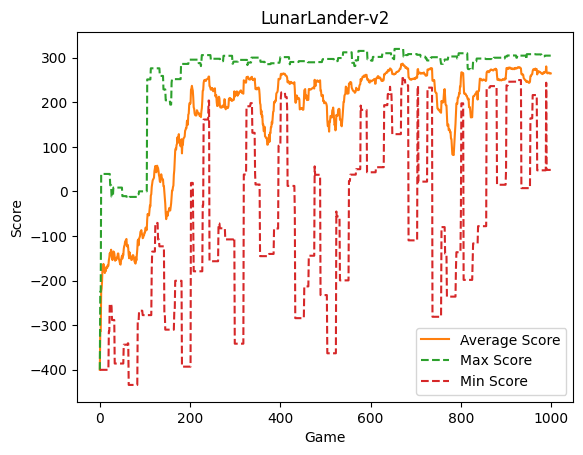

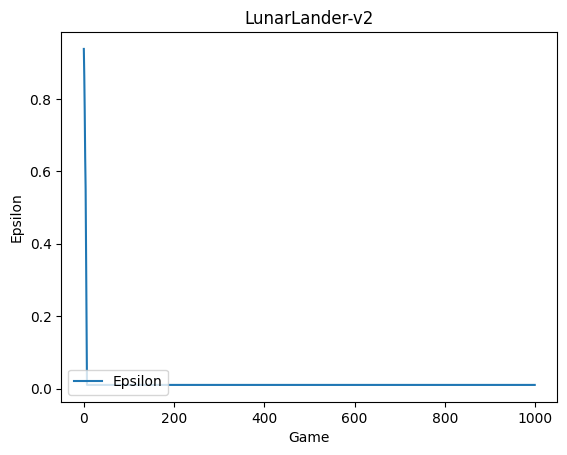

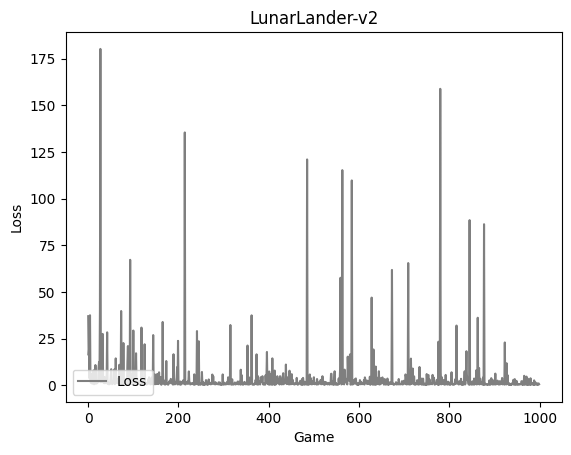

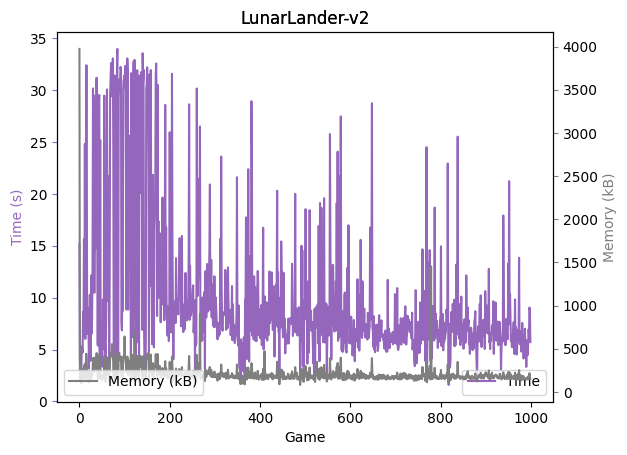

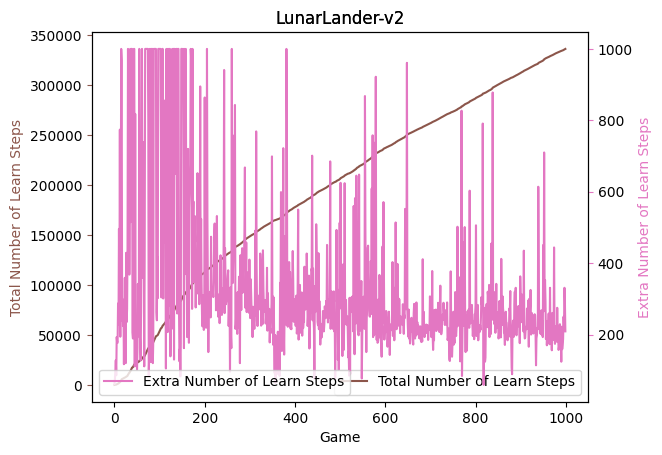

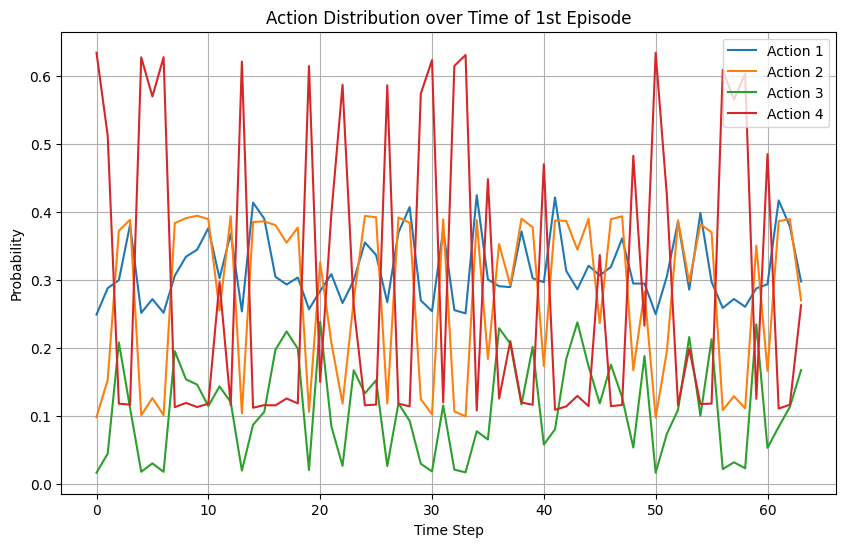

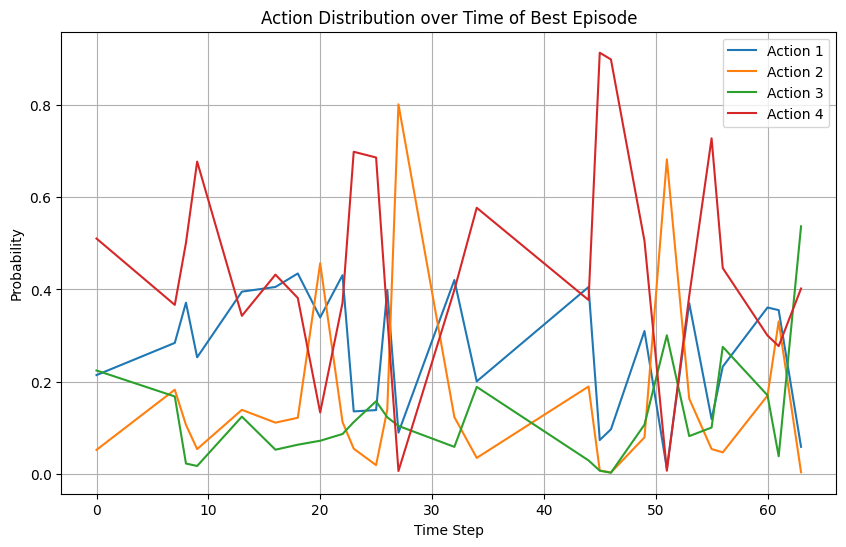

In [ ]:
__main__('LunarLander-v2', 4, 8, 1000)

# LunarLander-v2 - ANALYSIS

Firstly, the average reward line demonstrates a noticeable improvement throughout the games, with the most significant progress occurring before the 200th episode. Subsequently, the rate of improvement slows down, and the maximum reward stabilizes around 300. Therefore, the further evolution of the average reward is predominantly influenced by the minimum reward values, resulting in consistent fluctuations between the orange and red lines. This indicates that the model has already acquired a substantial understanding of the environmental mechanics after the 200th episode, achieving a commendable overall performance. However, as the agent continues to play, it encounters new situations or performs random actions (with a 1% chance), leading to punctual suboptimal behaviors indicated by drops in the minimum reward (red line). Nonetheless, the model continues to make progress, albeit at a slower pace, as the optimal outcome was achieved during episode 671.

The epsilon evolution graph, which depicts the exploration rate, rapidly reaches the established minimum value of 0.01 within 7 episodes. As a result, there are only a few episodes where it is probable that the agent chooses random actions, which may be suboptimal. However, this exploration rate is sufficient to prevent the agent from getting stuck in local minima and allows it to converge towards the global optimum. Thus, the majority of the learning process is dominated by exploitation, as the exploration chances are only 1%.

The Loss graph visually illustrates the agent's learning process, showing a gradual reduction in loss over time as expected. It is worth noting that the loss experiences some oscillation, similar to the reward evolutions, due to the agent encountering unfamiliar environmental states at the start of each episode or taking random exploration actions. These factors contribute to high negative rewards and, consequently, higher losses. Nevertheless, the overall pattern reveals a decreasing trend in loss, despite the fluctuations, indicating the agent's effective learning.

Regarding time complexity, there appears to be no clear relationship between the number of games and the time taken by the agent during the learning process. However, significant variations in time are observed between games, ranging from approximately 1 second to 34 seconds. Similar conclusions can be drawn when analyzing the memory results.

Furthermore, the total number of learning steps taken by the agent in each episode generally increases linearly. Notably, there is a distinct steep change in behavior before and after the 200th game, with the steeper increase occurring prior to that point. This observation aligns with the average reward evolution graph (orange line), as the most substantial improvement is observed in the interval between the initial episodes and the 200th episode. Beyond that point, the improvement continues but at a slower pace. Consequently, the additional number of learning steps is larger between episodes 0 and 200, averaging around 500 steps, and decreases to approximately 400 steps after the 200th episode.

Finally, the action distribution over time provides insights into the agent's decision-making process. In the first episode, there is a dominant action chosen by the agent due to its lack of knowledge about the environment. However, as the agent gains more experience through subsequent episodes, the probabilities associated with each action change, resulting in overlapping distributions. This indicates instances where the agent confidently chooses a particular action with a high probability or encounters uncertainty and struggles to decide among multiple actions. This shift reflects the agent's learning process, which leads to higher probabilities for certain actions in specific time steps and more balanced probabilities with increased overlap in others, a pattern not observed in the initial episode. It is worth mentioning that, owing to memory overflow issues, linear interpolation had to be implemented for the action distribution graph of the best episode (671).

In conclusion, as evidenced by the output, the model achieved its best agent configuration during episode 671, exhibiting the following characteristics:


*   Episode: 671;
*   Number of Learn Steps 255797 (+235 Steps);
*   Score 262.76;
*   Average Score (Last 20 runs) 286.74 (max 319.74; min 259.29);
*   Epsilon 0.01;
*   Loss 0.87977;
*   Time (s) 6.269;
*   Memory (kB) 157.704





# CartPole-v0 - RESULTS

## NOTE: Scroll to visualize all the results (print output + graphics)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-3-b3ecfa1f8771>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and i


Results from the CartPole-v0 environment:
Episode: 0; Number of Learn Steps 28 (+28 Steps); Score 37.00; Average Score (Last 20 runs) 37.00 (max 37.00; min 37.00); Epsilon 0.97; Loss 0.08105; Time (s) 3.350; Memory (kB) 1456.581
Episode: 1; Number of Learn Steps 39 (+11 Steps); Score 11.00; Average Score (Last 20 runs) 24.00 (max 37.00; min 11.00); Epsilon 0.96; Loss 0.04174; Time (s) 0.231; Memory (kB) 27.991
Episode: 2; Number of Learn Steps 57 (+18 Steps); Score 18.00; Average Score (Last 20 runs) 22.00 (max 37.00; min 11.00); Epsilon 0.94; Loss 0.01343; Time (s) 0.368; Memory (kB) 35.443
Episode: 3; Number of Learn Steps 84 (+27 Steps); Score 27.00; Average Score (Last 20 runs) 23.25 (max 37.00; min 11.00); Epsilon 0.92; Loss 0.00284; Time (s) 0.599; Memory (kB) 45.626
Episode: 4; Number of Learn Steps 104 (+20 Steps); Score 20.00; Average Score (Last 20 runs) 22.60 (max 37.00; min 11.00); Epsilon 0.90; Loss 0.29851; Time (s) 0.440; Memory (kB) 68.928
Episode: 5; Number of Learn S

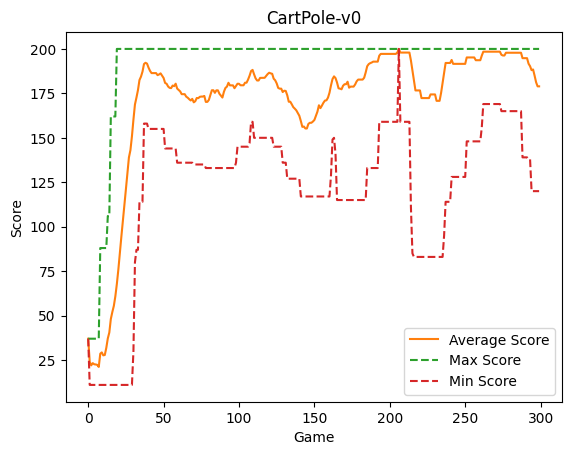

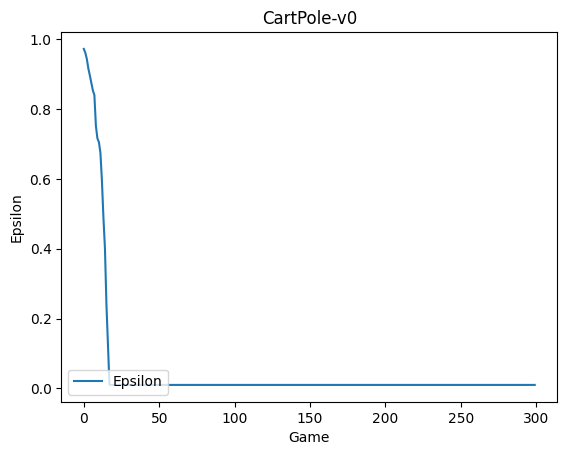

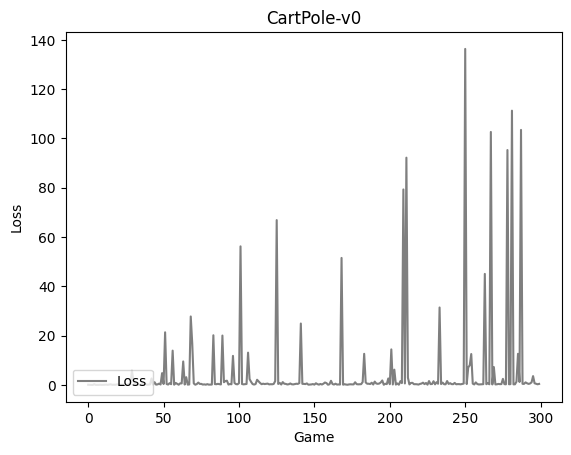

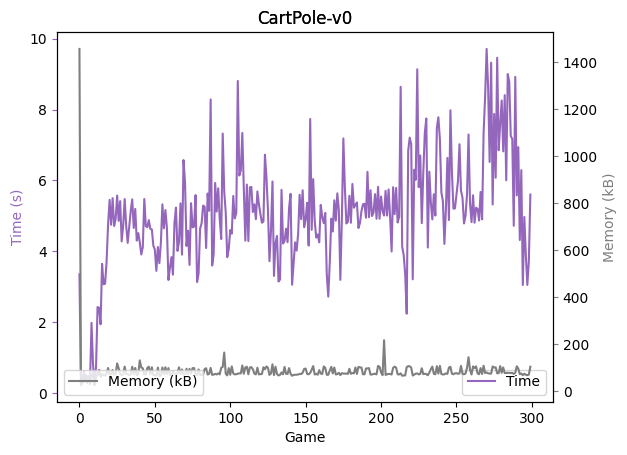

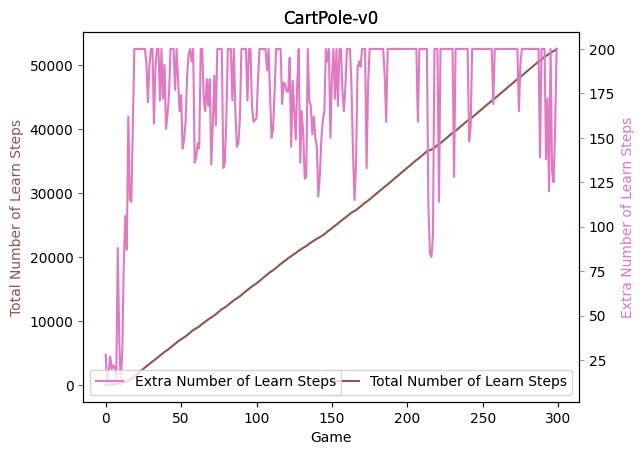

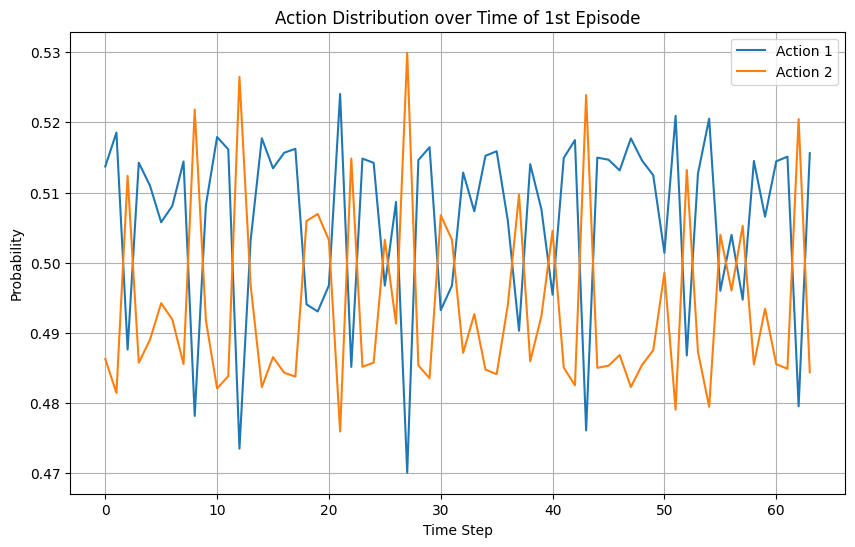

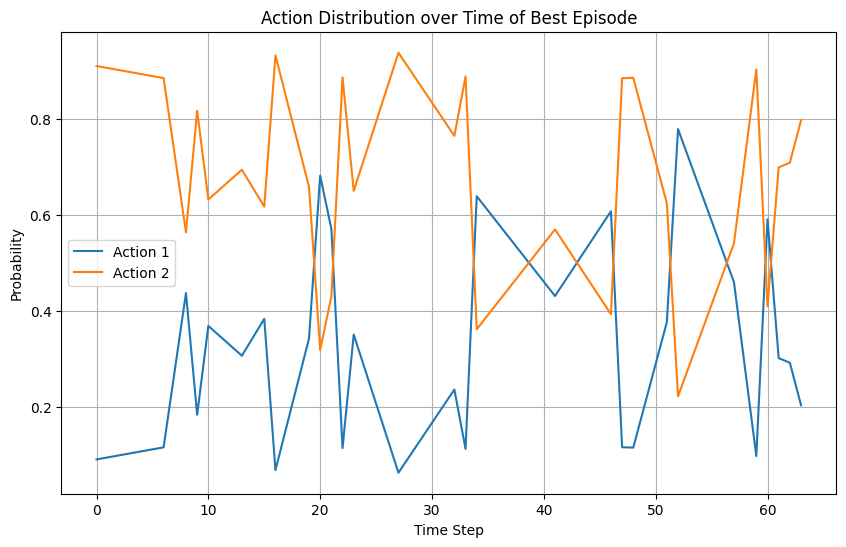

In [ ]:
__main__('CartPole-v0', 2, 4, 300)

# CartPole-v0 - ANALYSIS

The rewards evolution reveals a notable improvement during the initial 50 episodes of the learning process, as evidenced by the significant rise in average reward (orange line). Subsequently, the rate of improvement slows down, and by episode 206, the average reward reaches its maximum value (200.00), aligning with both the minimum and maximum rewards. This suggests that the agent's learning process could have been terminated at this point, as it appears to have reached its maximum capacity given the chosen model configuration. However, as the learning process continues, the reward lines oscillate as expected, with the agent encountering specific environmental states or performing random actions that contribute to suboptimal outcomes (local minima).

In terms of epsilon, the exploration phase is longer in this case, taking 17 episodes for epsilon to reach the minimum allowed value of 1%. Consequently, this phase plays a crucial role in facilitating a steep initial reward improvement by the agent. Beyond that episode, the agent primarily relies on exploitation, enabling it to maintain the positive reward evolution observed in the previous paragraph.

While not clearly visible in the graph, the loss values exhibit a decreasing trend over games until episode 206, where the agent achieves its maximum performance. After this point, no further improvements are recorded, resulting in high variations in loss without any corresponding benefits. This reinforces the notion that the agent could cease its learning process after the 206th episode.

In terms of time and memory complexities, similar conclusions can be drawn as in the previous environment. However, in this case, due to the environment's lower complexity, both metrics indicate lower values.

In terms of learning steps, the total number of steps (brown line) follows a linear progression. In fact, this evolution is even more linear compared to the previous environment, likely due to the simplicity of the environment itself. Consequently, the average number of additional steps is around 200, with some oscillations, particularly in the initial episodes, where a significant increase was observed.

Lastly, in accordance with expectations and previous observations, it is worth noting that the actions taken by the agent in the initial episode consistently exhibit low probabilities, as the highest value attained was only 53%. Nevertheless, as the learning process advances, the action probabilities become more prominent across various instances, as the model has acquired knowledge and can discern the correct action. Consequently, the majority of these probabilities exceed 60%, with a significant portion surpassing 80%. This shift signifies the agent's enhanced understanding and its capacity to evaluate diverse actions based on acquired information.

In conclusion, as evidenced by the output, the model achieved its best agent configuration during episode 671, exhibiting the following characteristics:

*   Episode: 206;
*   Number of Learn Steps 35195 (+200 Steps);
*   Score 200.00;
*   Average Score (Last 20 runs) 200.00 (max 200.00; min 200.00);
*   Epsilon 0.01;
*   Loss 0.08297;
*   Time (s) 4.972;
*   Memory (kB) 73.220

# CONCLUSION

In conclusion, the analysis of the "Dueling DQN" agent's performance in the LunarLander-v2 and CartPole-v0 environments provides valuable insights into its learning process and behavior.

The average reward evolution demonstrates a clear improvement over time, with significant progress observed in the early episodes. After reaching a certain point, the rate of improvement slows down, indicating that the agent has already learned the majority of the environmental mechanics. Therefore, when the maximum performance for the developed model is reached, the agent should stop the learning process.

The Loss graph illustrates the agent's learning process, showing a gradual reduction in loss over time, despite some oscillation. This reduction indicates that the agent is effectively learning and adjusting its policy to maximize rewards. Since the epsilon evolution graph highlights the exploration rate, which rapidly decreases to a minimum value, the agent primarily exploits its learned knowledge while still maintaining a small exploration chance to avoid local minima.

Time and memory complexities vary between games but do not exhibit a clear relationship with the number of episodes. Morevover, the total number of learning steps generally increases linearly, in which the extra steps taken depend on the complexity of the environmnet to be learned.

The action distribution over time reflects the agent's decision-making process. Initially, the agent relies on a dominant action due to its lack of knowledge. As it learns, the probabilities associated with each action change, leading to overlapping distributions and instances of both confident and uncertain decisions.

Overall, the "Dueling DQN" agent demonstrates the ability to learn and improve its performance in both environments. The analysis provides valuable insights into its learning process, highlighting the importance of early improvements, exploration-exploitation balance, and the influence of memory and time complexities.

# REFERENCES

[1] WANG, Z. *et al.* (2015). *Dueling Network Architectures for Deep Reinforcement Learning*. UK: Google DeepMind.